In [3]:
import cv2
import numpy as np
import pandas as pd
from skimage import io
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist



In [4]:
def power_iteration(A, num_iterations=100):
    # Initialize a random vector as the starting point
    v = np.random.rand(A.shape[0])

    for _ in range(num_iterations):
        # Power Iteration step
        Av = np.dot(A, v)
        # Compute the eigenvalue
        eigenvalue = np.dot(v, Av)
        # Normalize the eigenvector
        v = Av / np.linalg.norm(Av)

    return eigenvalue, v

def eigen_decomposition(A, num_components=None):
    n = A.shape[0]

    if num_components is None:
        num_components = n

    eigenvalues = np.zeros(num_components)
    eigenvectors = np.zeros((n, num_components))

    for i in range(num_components):
        # Get the dominant eigenvalue and corresponding eigenvector
        eigenvalue, eigenvector = power_iteration(A)

        # Store the results
        eigenvalues[i] = eigenvalue
        eigenvectors[:, i] = eigenvector

        # Deflate A by subtracting the outer product
        A = A - eigenvalue * np.outer(eigenvector, eigenvector)

    return eigenvalues, eigenvectors


In [5]:
class PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def my_mean(self, X):
        return np.sum(X, axis=0) / X.shape[0]

    def my_cov(self, X, rowvar=False):
        if rowvar:
            X = X.T
        n = X.shape[1]
        covariance_matrix = (X.T @ X) / (n - 1)
        return covariance_matrix

    def my_eigh(self, A):
        self.eigenvalues, eigenvectors= eigen_decomposition(A)
        return self.eigenvalues, eigenvectors

    def my_argsort(self, arr):
        n = len(arr)
        indices = list(range(n))
        for i in range(1, n):
            key = arr[i]
            j = i - 1
            while j >= 0 and key > arr[j]:
                arr[j + 1] = arr[j]
                indices[j + 1] = indices[j]
                j -= 1
            arr[j + 1] = key
            indices[j + 1] = i
        return indices
    def fit(self, X):
        self.mean = self.my_mean(X)
        centered_data = X - self.mean

        cov_matrix = self.my_cov(centered_data, rowvar=False)
        eigenvalues, eigenvectors = self.my_eigh(cov_matrix)

        sorted_indices = self.my_argsort(eigenvalues)
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        self.explained_variance_ = eigenvalues
        self.components = eigenvectors

        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
            self.explained_variance_ = eigenvalues[:self.n_components]

        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance

    def transform(self, X):
        centered_data = X - self.mean
        reduced_data = centered_data @ self.components
        return reduced_data

    def inverse_transform(self, compressed_image):
        return compressed_image @ self.components.T + self.mean


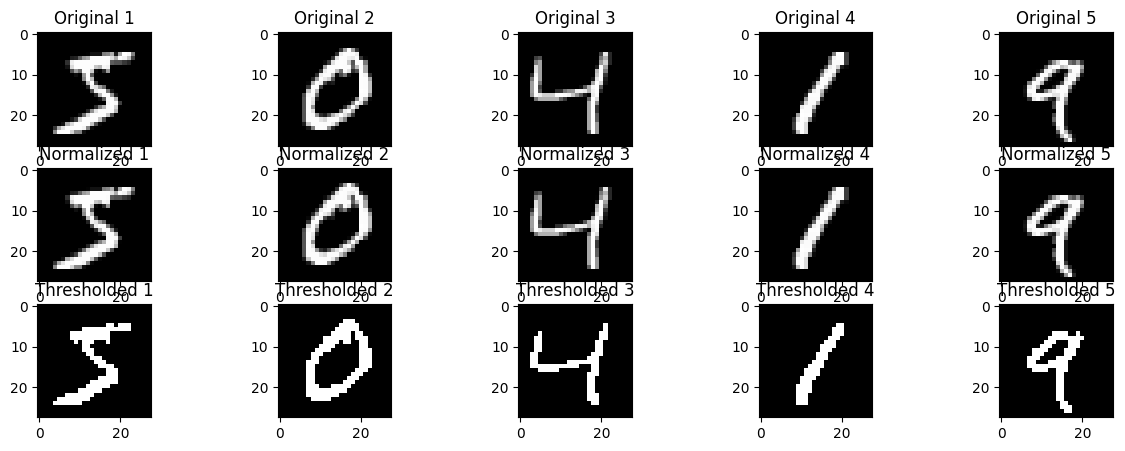

In [6]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to the range [0, 1]
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

# Threshold the normalized values to 1 if >= 0.5
x_train_thresholded = np.round(np.where(x_train_normalized >= 0.5, 1.0, 0.0))
x_test_thresholded = np.round(np.where(x_test_normalized >= 0.5, 1.0, 0.0))

num_samples = 5

plt.figure(figsize=(15, 5))

for i in range(num_samples):
    # Original Image
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Original {i + 1}")

    # Normalized Image
    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(x_train_normalized[i], cmap='gray')
    plt.title(f"Normalized {i + 1}")

    # Thresholded Image
    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title(f"Thresholded {i + 1}")

plt.show()

In [7]:
print(x_train_thresholded[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

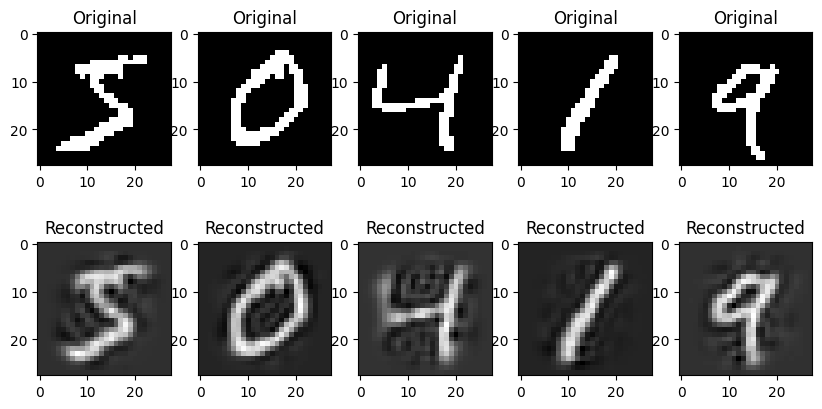

In [8]:
original_images = x_train_thresholded.reshape(len(x_train_thresholded), -1)

# Display some original samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title('Original')

# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(original_images)
pca_result = pca.transform(original_images)

# Reconstruct the images
reconstructed_images = pca.inverse_transform(pca_result)

# Reshape reconstructed images
reconstructed_images = reconstructed_images.reshape(len(x_train_thresholded), 28, 28)

# Display some reconstructed samples
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')

plt.show()


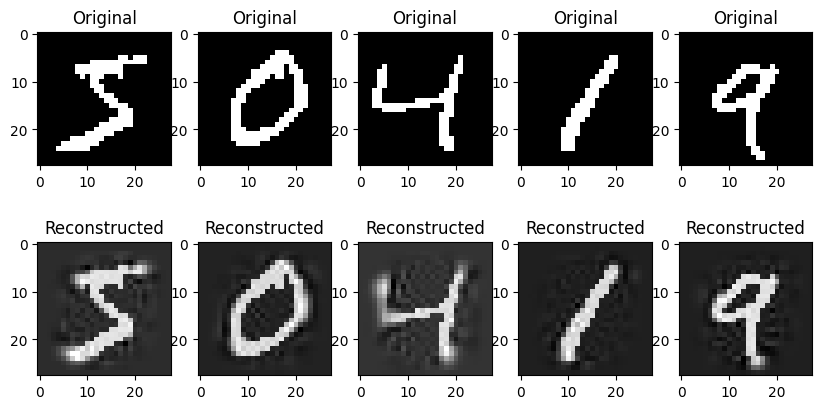

In [35]:
# Display some original samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title('Original')
# Apply PCA
n_components = 250
pca = PCA(n_components=n_components)
pca.fit(original_images)
pca_result = pca.transform(original_images)

# Reconstruct the images
reconstructed_images = pca.inverse_transform(pca_result)

# Reshape reconstructed images
reconstructed_images = reconstructed_images.reshape(len(x_train_thresholded), 28, 28)

# Display some reconstructed samples
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')

plt.show()

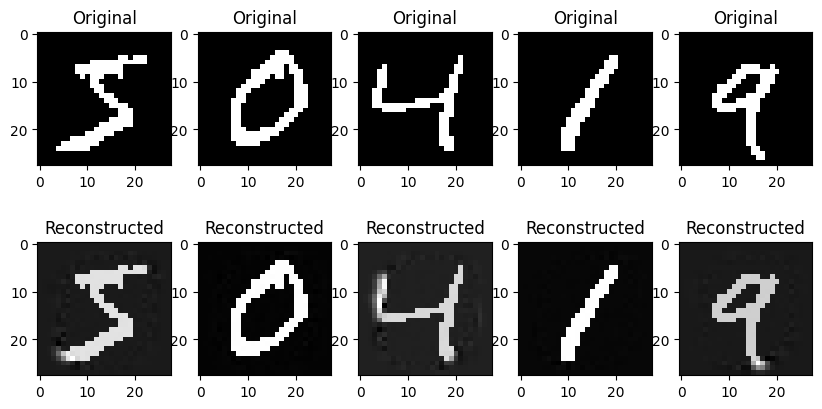

In [37]:
# Display some original samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_thresholded[i], cmap='gray')
    plt.title('Original')
# Apply PCA
n_components = 400
pca = PCA(n_components=n_components)
pca.fit(original_images)
pca_result = pca.transform(original_images)

# Reconstruct the images
reconstructed_images = pca.inverse_transform(pca_result)

# Reshape reconstructed images
reconstructed_images = reconstructed_images.reshape(len(x_train_thresholded), 28, 28)

# Display some reconstructed samples
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title('Reconstructed')

plt.show()

In [27]:
x = x_train_thresholded.reshape(len(x_train_thresholded), -1)
mean = np.mean(x, axis=0)
centered_data = x - mean
cov_matrix = np.cov(centered_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]


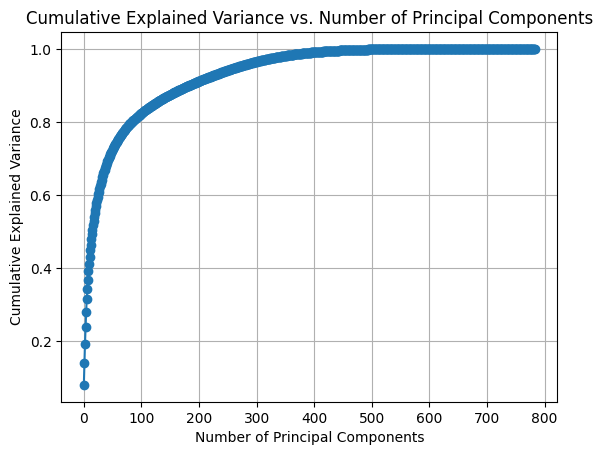

In [28]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

#from the above plot and the trails of different Q-matrices the result is best at 400 component and doesnt chane alot with Q-matrix more than 400  #

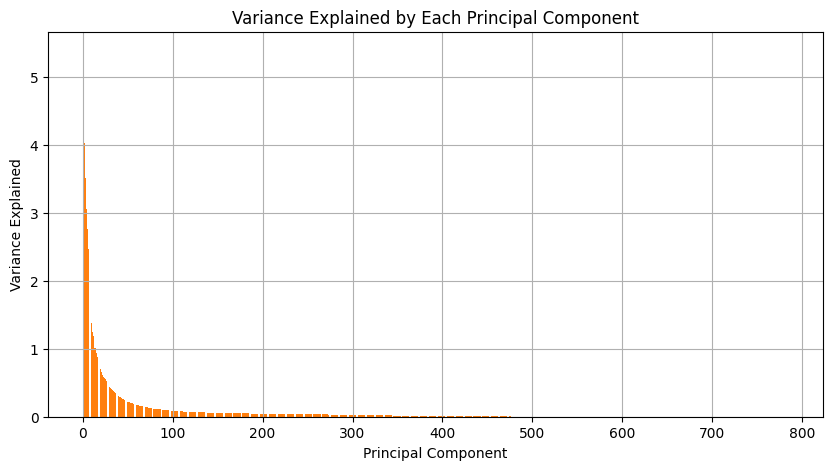

In [29]:
explained_variance = eigenvalues
plt.figure(figsize=(10, 5))
indices = np.arange(1, len(explained_variance) + 1)
plt.bar(indices, explained_variance[indices - 1])
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.grid()
plt.show()

In [11]:
#Pca with cov and eignvalues and eignvectors built in
class BI_PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
        # covariance, function needs samples as columns
        #row = 1 sample, columns = feature
        cov = np.cov(X.T)
        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.components = eigenvectors[0:self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)
    def inverse_transform(self,compressed_image):
        return np.dot(compressed_image,  self.components) + self.mean

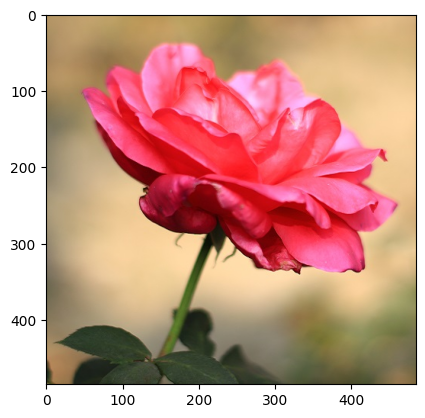

In [12]:
img = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/lfwcrop_grey/rose.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [13]:
blue,green,red = cv2.split(img)
s_blue = blue/255
s_green = green/255
s_red = red/255
#our implemened pca
pca_b = PCA(n_components=50)
pca_b.fit(s_blue)
trans_pca_b = pca_b.transform(s_blue)

pca_g = PCA(n_components=50)
pca_g.fit(s_green)
trans_pca_g = pca_g.transform(s_green)

pca_r = PCA(n_components=50)
pca_r.fit(s_red)
trans_pca_r = pca_r.transform(s_red)

b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)

img_reduced= cv2.merge((b_arr, g_arr, r_arr))
print(img_reduced.shape)

(485, 485, 3)


In [14]:
#built in functions pca
pca_B = BI_PCA(n_components=50)
pca_B.fit(s_blue)
trans_pca_B = pca_B.transform(s_blue)

pca_G = BI_PCA(n_components=50)
pca_G.fit(s_green)
trans_pca_G = pca_G.transform(s_green)

pca_R = BI_PCA(n_components=50)
pca_R.fit(s_red)
trans_pca_R = pca_R.transform(s_red)

b_arr = pca_B.inverse_transform(trans_pca_B)
g_arr = pca_G.inverse_transform(trans_pca_G)
r_arr = pca_R.inverse_transform(trans_pca_R)

img_reduced_BI= cv2.merge((b_arr, g_arr, r_arr))
print(img_reduced.shape)

(485, 485, 3)


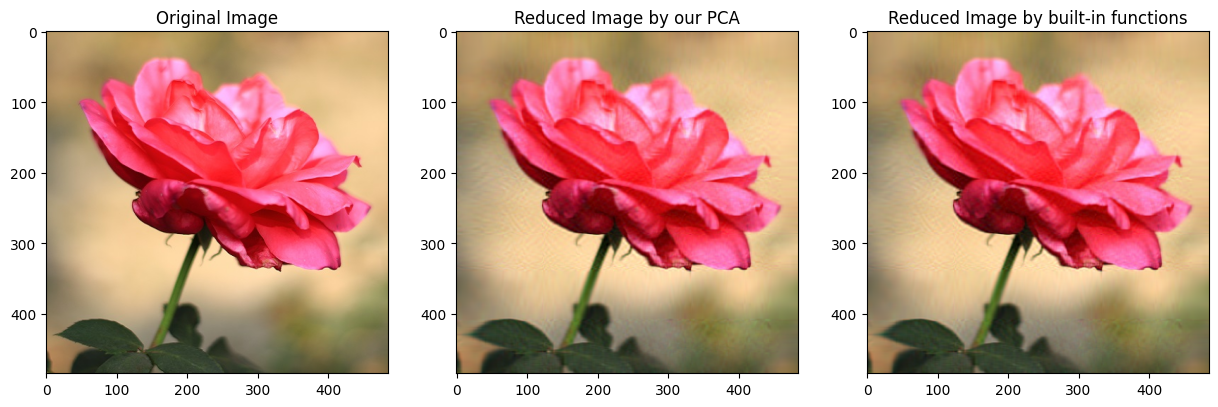

In [33]:
# Original Image
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Original Image")
plt.imshow(img)

# Reduced Image by our PCA
plt.subplot(132)
plt.title("Reduced Image by our PCA")
plt.imshow(img_reduced)

# Reduced Image by built-in functions
plt.subplot(133)
plt.title("Reduced Image by built-in functions")
plt.imshow(img_reduced_BI)

plt.show()
